<a href="https://colab.research.google.com/github/yanapatt/Smart-Skin-Cancer-Assistant-CNN-Model/blob/main/PreparationDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparation Dataset**
---
**คำอธิบาย**  
ไฟล์ Jupyter notebook นี้ใช้สำหรับการจัดเตรียมรูปภาพให้พร้อมก่อนที่จะนำภาพเข้าโมเดล CNN ซึ่งประกอบไปด้วย

1.   การโหลด Dataset จาก Kaggle
2.   การจัดเตรียม Directory สำหรับดึง Image ไปใช้งาน
3.   การแบ่งข้อมูล Training, Validation และ Testing โดยเก็บเป็น Index ในรูปแบบ .csv เพื่อใช้ซ้ำในครั้งถัดไป
4.   การ Visualization images เพื่อรายงานผลเบื้องต้นเกี่ยวกับ Dataset
5.   เสริมการแก้ Imbalanced Dataset ด้วยการ Augmentation

---
**Group Oscar Do Everything**  
**หัวข้อ Smart Skin Cancer Assistant CNN Model**  
**สมาชิก**  

* 66102010137	นายณัฐนนท์ หลิมเหล็ก
* 66102010145	นายพชรดนัย กุระกนก
* 66102010153	นายศิลายุชย์ โชติธรรมาภรณ์
* 66102010236	นายญาณภัทร ปานเกษม

**รายวิชา**
**CP461 Introduction to Computer Vision**

**Main Reference : An Interpretable Deep Learning Approach for Skin Cancer Categorization**  

**Paper Link:** https://arxiv.org/abs/2312.10696  
**GitHub:** https://github.com/Faysal-MD/An-Interpretable-Deep-Learning-Approach-for-Skin-Cancer-Categorization-IEEE2023?utm_source=chatgpt.com  
**EDA:** https://www.kaggle.com/code/abhishekgbhat/eda-cnn-architecture-tuning-80-83-accuracy#Univariate-EDA

## **Section 0: Import important library**

In [1]:
import pandas as pd
import numpy as np
import random as rd
import tensorflow as tf
import keras
import sklearn
import joblib

import kagglehub
import os
import shutil
import glob
from tqdm import tqdm
import albumentations as A

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import missingno as msno
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Setting a seed system environment**

In [3]:
def set_seed(seed):
    """
        ใช้สำหรับการตั้งค่า Seed Environment เพื่อให้ผลลัพธ์สามารถ Reproduce ได้
        Arg:
            seed คือ ค่า Integer สำหรับกำหนด Seed
    """
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
    keras.utils.set_random_seed(seed)

    np.random.seed(seed)
    rd.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"

    print(f"The seed number has been set at {seed}")

In [4]:
SEED = 42
set_seed(SEED)

The seed number has been set at 42


## **Section 1: Preparing the directory for dataset**

### **In G-Drive Directory**

In [5]:
DRIVE_DIR = "/content/drive/MyDrive/CP461/mainProject" # Drive Directory
ASSETS_PATH = f"{DRIVE_DIR}/assets" # Assets Path
ASSETS_VISUALIZE_IMG_PATH = f"{ASSETS_PATH}/images" # Visualize Image Assets Path
DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000Dataset"
#OVER_DATASET_ZIP_PATH = f"{DRIVE_DIR}/datasets/ham10000DatasetOversampling"
INDEX_PATH = f"{DRIVE_DIR}/datasets/indexSetting"

In [6]:
# Setting font
fm.fontManager.addfont(f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_prop = fm.FontProperties(fname=f"{ASSETS_PATH}/fonts/OPTITimes-Roman.otf")
font_name = font_prop.get_name()
plt.rcParams["font.family"] = font_name

### **In Runtime Directory**

In [7]:
KAGGLE_BASE_DIR = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", KAGGLE_BASE_DIR)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [8]:
METADATA_PATH = f"{KAGGLE_BASE_DIR}/HAM10000_metadata.csv"
IMAGE_PART_ONE = f"{KAGGLE_BASE_DIR}/HAM10000_images_part_1"
IMAGE_PART_TWO = f"{KAGGLE_BASE_DIR}/HAM10000_images_part_2"

In [9]:
IMAGE_PART_ONE_PATH = glob.glob(os.path.join(IMAGE_PART_ONE, "*.jpg"))
IMAGE_PART_TWO_PATH = glob.glob(os.path.join(IMAGE_PART_TWO, "*.jpg"))
MERGE_IMAGES = IMAGE_PART_ONE_PATH + IMAGE_PART_TWO_PATH
MERGE_DIR = "/content/ham10000Dataset"

In [10]:
paths_dict = {os.path.basename(x).split(".")[0] : x for x in MERGE_IMAGES}
print(f"Number of dictionary elements: {len(paths_dict)}")

Number of dictionary elements: 10015


In [11]:
BASE_DATASET_DIR = "/content/ham10000Dataset"
#OVER_DATASET_DIR = "/content/ham10000DatasetOversampling"

##**Section 2: Exploratory Data Analysis (EDA)**

### **Read metadata**

In [12]:
metadata = pd.read_csv(METADATA_PATH)
metadata

lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]

In [13]:
print("Metadata before cleaning detail")
print("-------------------------------------------")
print(f"Shape of metadata: {metadata.shape}")
print(f"Row of metadata: {metadata.shape[0]}")
print(f"Column of metadata: {metadata.shape[1]}")
print("-------------------------------------------")
print("Check missing value")
print("-------------------------------------------")
print(metadata.isnull().sum())
print("-------------------------------------------")
print("Check data type")
print("-------------------------------------------")
print(metadata.dtypes)
print("Check duplicate value")
print("-------------------------------------------")
print(f"Duplicate value count : {metadata.duplicated().sum()}")

Metadata before cleaning detail
-------------------------------------------
Shape of metadata: (10015, 7)
Row of metadata: 10015
Column of metadata: 7
-------------------------------------------
Check missing value
-------------------------------------------
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64
-------------------------------------------
Check data type
-------------------------------------------
lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object
Check duplicate value
-------------------------------------------
Duplicate value count : 0


<Axes: >

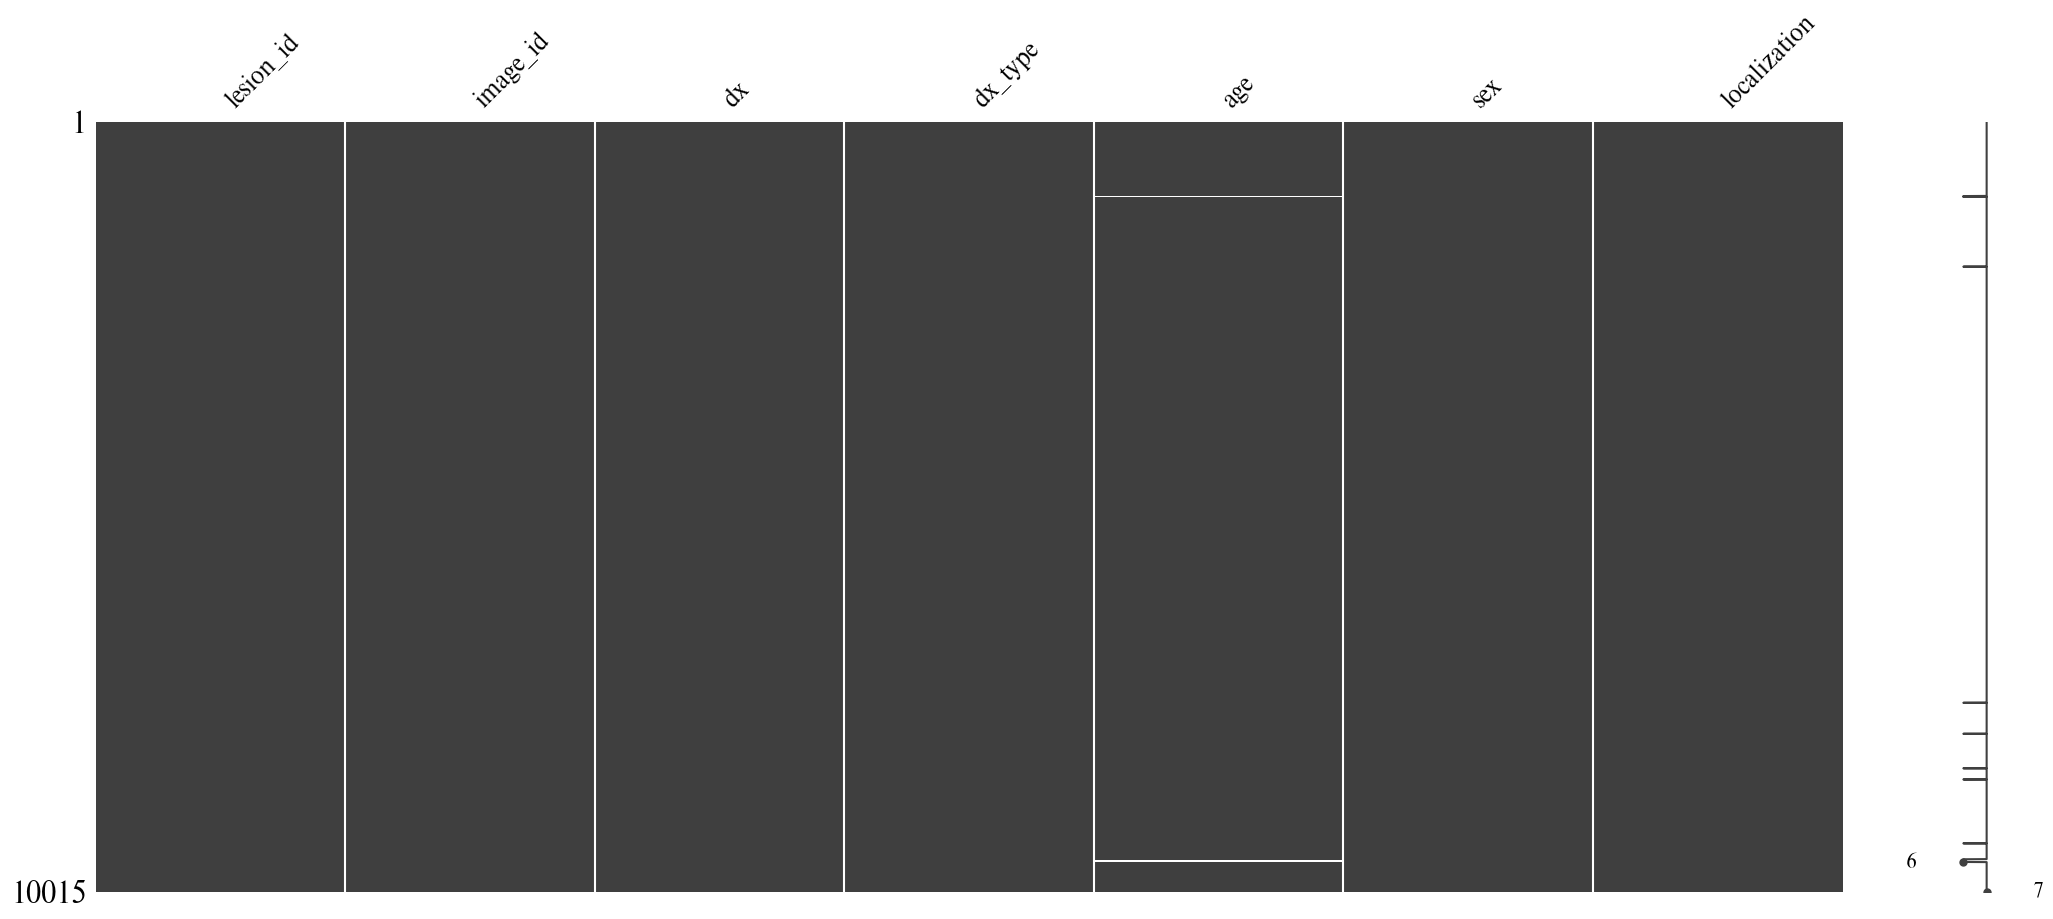

In [14]:
msno.matrix(metadata)

In [15]:
print("Metadata age describe")
print("-------------------------------------------")
print(metadata["age"].describe())
print("Metadata age median")
print("-------------------------------------------")
print(f"Age median: {metadata['age'].median()}")

Metadata age describe
-------------------------------------------
count    9958.000000
mean       51.863828
std        16.968614
min         0.000000
25%        40.000000
50%        50.000000
75%        65.000000
max        85.000000
Name: age, dtype: float64
Metadata age median
-------------------------------------------
Age median: 50.0


In [16]:
clean_df = metadata.copy()

### **Handle missing value for age column**

In [17]:
age_median = clean_df["age"].median()
clean_df["age"] = clean_df["age"].fillna(age_median) # แทนที่ค่า NaN ด้วยค่ามัธยฐานของอายุ

print("Check missing value")
print("-------------------------------------------")
print(clean_df.isnull().sum())
print("-------------------------------------------")

Check missing value
-------------------------------------------
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64
-------------------------------------------


<Axes: >

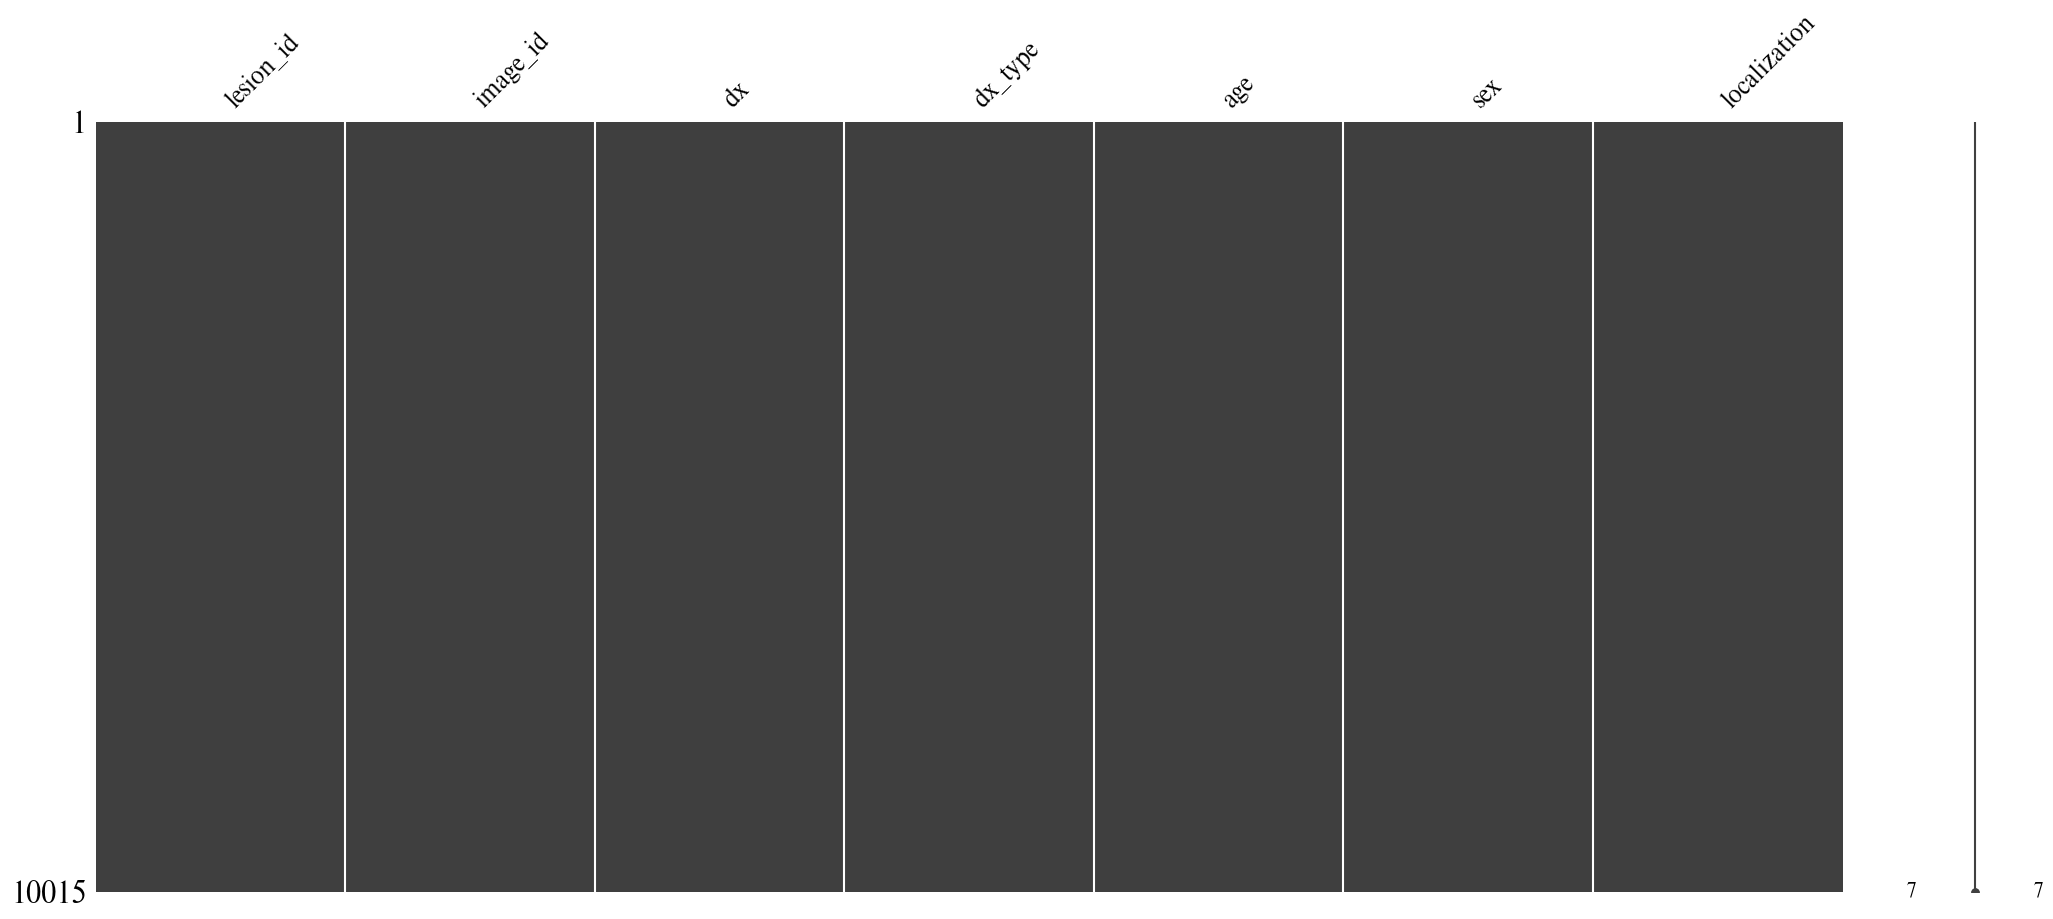

In [18]:
msno.matrix(clean_df)

### **Mapping imagepath, full label and class index**

In [19]:
lesion_type_dict = {
    "akiec": "Actinic keratoses",
    "bcc": "Basal cell carcinoma",
    "bkl": "Benign keratosis-like lesions",
    "df": "Dermatofibroma",
    "mel": "Melanoma",
    "nv": "Melanocytic nevi",
    "vasc": "Vascular lesions"
} # เพื่อให้ลำดับ Index เหมือนตอน Train โมเดล

lesion_type_mapping = {v: k for k, v in enumerate(lesion_type_dict.values())}

clean_df["filepaths"] = clean_df["image_id"].map(paths_dict.get)
clean_df["cell_type"] = clean_df["dx"].map(lesion_type_dict.get)
clean_df["cell_type"] = pd.Categorical(
    clean_df["cell_type"],
    categories=[lesion_type_dict[k] for k in lesion_type_dict.keys()],
    ordered=True
)
clean_df["cell_type_idx"] = clean_df["cell_type"].cat.codes

clean_df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                               filepaths  \
0      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
...                                                  ...   
10010  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10011  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10012  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10013  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10014  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                           cell_type  cell_type_idx  
0      Benign keratosis-like lesions              2  
1      Benign keratosis-like lesions              2  
2      Benign keratosis-like lesions              2  
3      Benign keratosis-like lesions              2  
4      Benign keratosis-like lesions              2  
...                              ...            ...  
10010              Actinic keratoses              0  
10011              Actinic keratoses              0  
10012              Actinic keratoses              0  
10013              Actinic keratoses              0  
10014                       Melanoma              4  

[10015 rows x 10 columns]

In [20]:
print("Recheck class index and cell type")
clean_df[["dx", "cell_type", "cell_type_idx"]].drop_duplicates().sort_values("cell_type_idx").reset_index(drop=True)

Recheck class index and cell type


dx                      cell_type  cell_type_idx
0  akiec              Actinic keratoses              0
1    bcc           Basal cell carcinoma              1
2    bkl  Benign keratosis-like lesions              2
3     df                 Dermatofibroma              3
4    mel                       Melanoma              4
5     nv               Melanocytic nevi              5
6   vasc               Vascular lesions              6

### **Univariate EDA**

In [72]:
def plot_univariate_distributions(df, save_path=None, fontsize=20):
    """
    ฟังก์ชันนี้ใช้สร้างกราฟแสดงการแจกแจงตัวแปรเดี่ยว (Univariate Distributions)
    จาก DataFrame ที่มีคอลัมน์ ['age', 'sex', 'dx_type', 'localization']

    Args:
        df (DataFrame): ข้อมูลที่ต้องการวิเคราะห์ โดยต้องมีคอลัมน์ 'age', 'sex', 'dx_type', 'localization'
        save_path (str, optional): ถ้าระบุ จะบันทึกภาพกราฟเป็นไฟล์ PNG และ SVG
        fontsize (int, optional): ขนาดตัวอักษรฐานสำหรับ Label และ Title (default=20)
    """
    plt.rcParams['axes.titlesize'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize * 0.85
    plt.rcParams['xtick.labelsize'] = fontsize * 0.75
    plt.rcParams['ytick.labelsize'] = fontsize * 0.75

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    sns.despine(left=True)

    # ---- [0, 0] Age Distribution (KDE) ----
    sns.kdeplot(data=df, x="age", fill=True, color="skyblue", ax=axes[0, 0])
    axes[0, 0].set_xlabel("Age")
    axes[0, 0].set_title("Age Distribution", fontsize=fontsize)

    # ---- [0, 1] Gender Distribution ----
    sns.countplot(data=df, x="sex", hue="sex", palette="pastel", legend=False, ax=axes[0, 1])
    axes[0, 1].set_xlabel("Gender")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].set_title("Gender Distribution", fontsize=fontsize)
    axes[0, 1].tick_params(axis='x', rotation=30)

    # ---- [1, 0] Diagnosis Test Type ----
    sns.countplot(data=df, x="dx_type", hue="dx_type", palette="muted", legend=False, ax=axes[1, 0])
    axes[1, 0].set_xlabel("Diagnosis Test Type")
    axes[1, 0].set_ylabel("Count")
    axes[1, 0].set_title("Diagnosis Test Type Distribution", fontsize=fontsize)
    axes[1, 0].tick_params(axis='x', rotation=30)

    # ---- [1, 1] Lesion Localization ----
    sns.countplot(data=df, x="localization", hue="localization", palette="Set2", legend=False, ax=axes[1, 1])
    axes[1, 1].set_xlabel("Localization Area")
    axes[1, 1].set_ylabel("Count")
    axes[1, 1].set_title("Localization Area Distribution", fontsize=fontsize)
    axes[1, 1].tick_params(axis='x', rotation=90)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.suptitle("Univariate Distributions", fontsize=fontsize * 1.2)

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

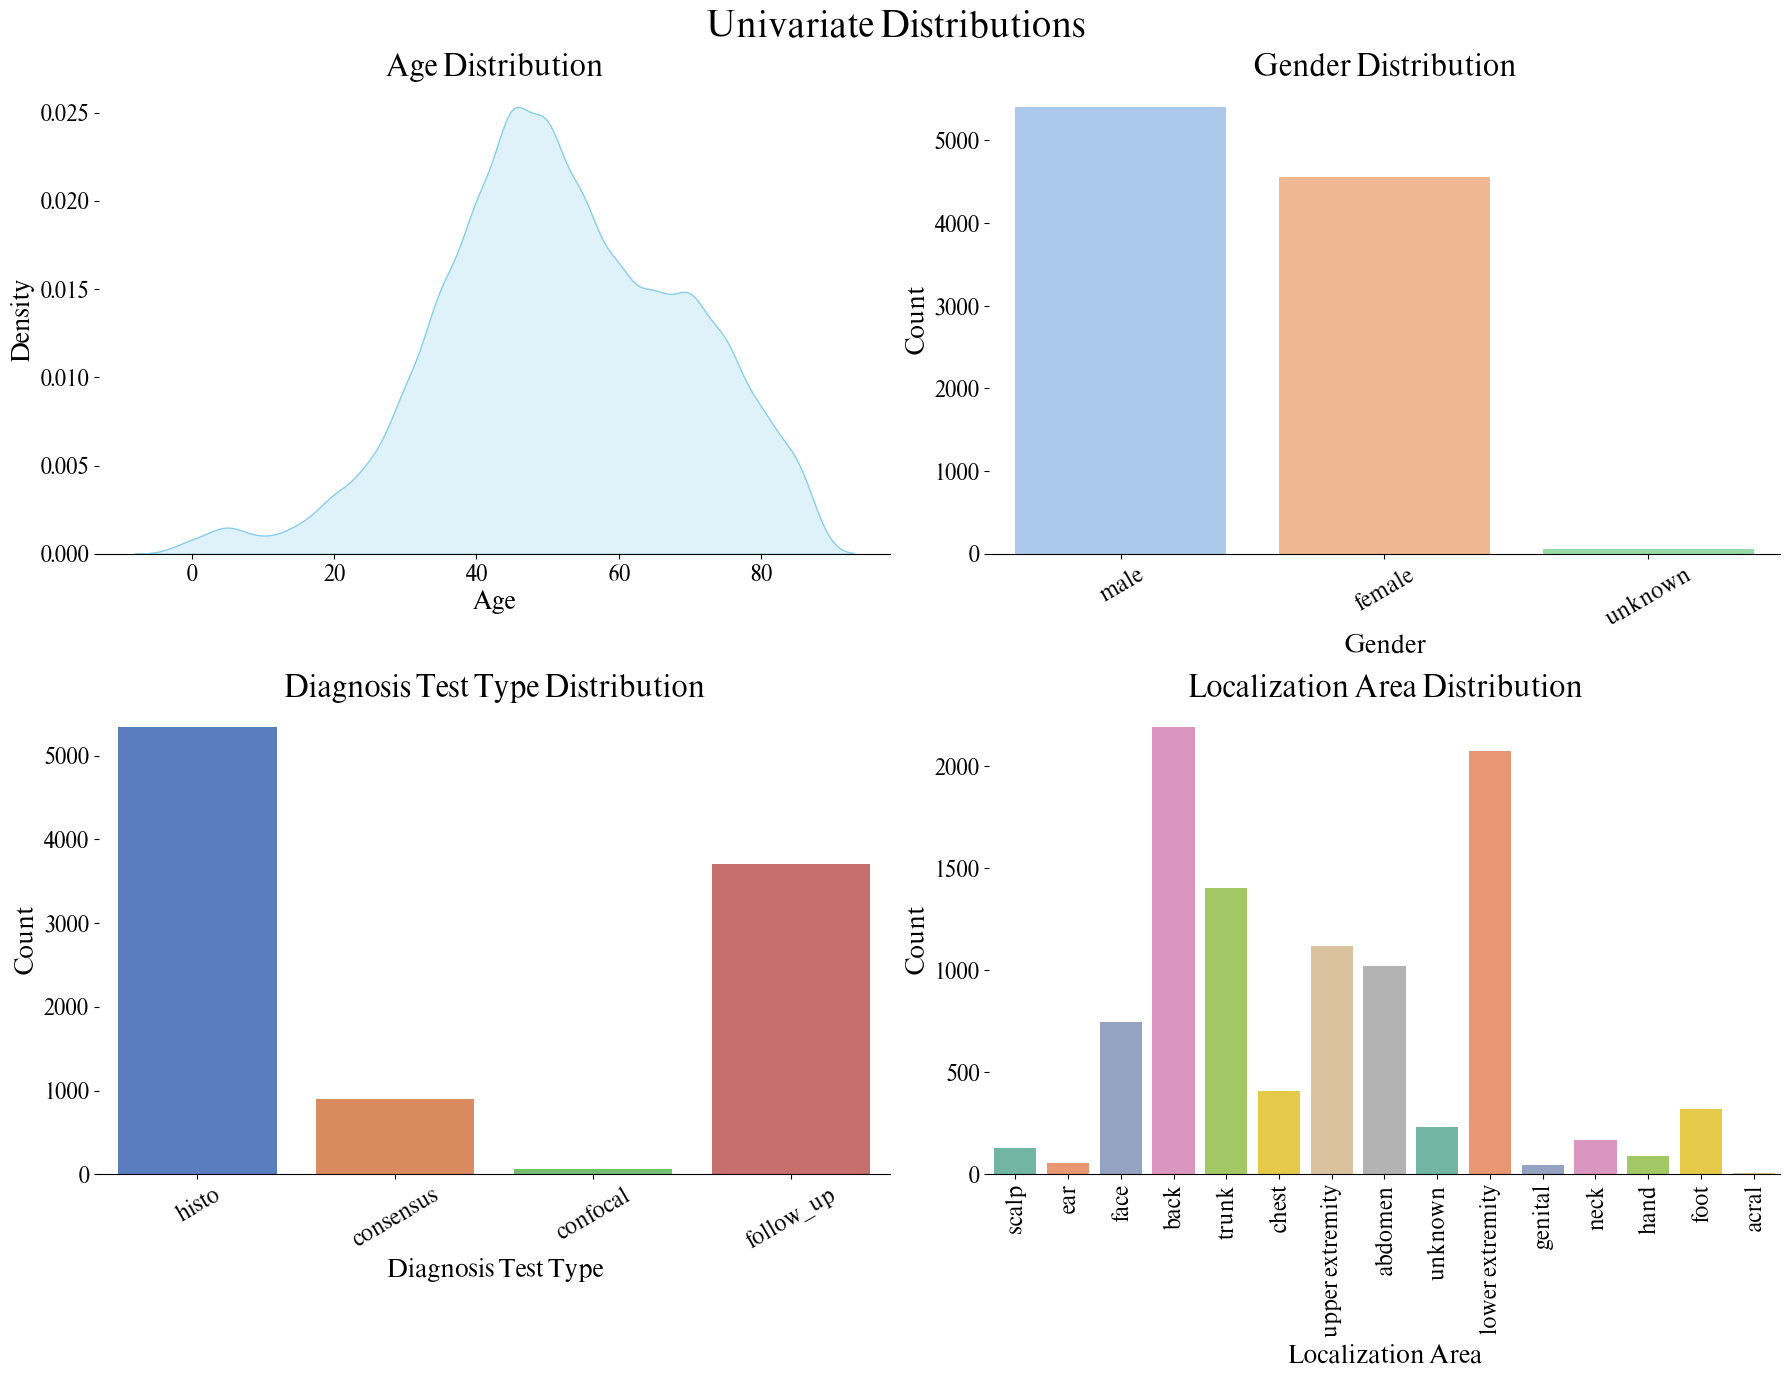

In [22]:
plot_univariate_distributions(
    df=clean_df,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/univariate_distributions",
    fontsize=20
)

### **Bivariate EDA**

In [73]:
def plot_age_boxplots(df, fontsize=20, save_path=None):
    """
    ฟังก์ชันนี้ใช้สร้างกราฟกล่อง (Boxplot) แสดงการกระจายอายุ
    โดยเปรียบเทียบตามเพศ (sex) และประเภทรอยโรค (dx)

    Args:
        df (DataFrame): ข้อมูลที่ต้องมีคอลัมน์ 'age', 'sex', 'dx'
        fontsize (int, optional): ขนาดตัวอักษรฐานสำหรับ labels และ titles
        save_path (str, optional): ถ้าระบุ จะบันทึกกราฟเป็นไฟล์ PNG และ SVG
    """
    plt.rcParams['axes.titlesize'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize * 0.85
    plt.rcParams['xtick.labelsize'] = fontsize * 0.75
    plt.rcParams['ytick.labelsize'] = fontsize * 0.75

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    sns.despine(left=True)

    # Gender vs Age
    sns.boxplot(x="sex", y="age", data=df, hue="sex", palette="pastel", legend=False, ax=axes[0])
    axes[0].set_xlabel("Gender")
    axes[0].set_ylabel("Age")
    axes[0].set_title("Gender vs Age Boxplot", fontsize=fontsize-2)
    axes[0].tick_params(axis="x", rotation=30)

    # Lesion Type vs Age
    sns.boxplot(x="dx", y="age", data=df, hue="dx", palette="muted", legend=False, ax=axes[1])
    axes[1].set_xlabel("Lesion Type")
    axes[1].set_ylabel("Age")
    axes[1].set_title("Lesion Type vs Age Boxplot", fontsize=fontsize-2)
    axes[1].tick_params(axis="x", rotation=30)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    fig.suptitle("Bivariate Distribution", fontsize=fontsize * 1.1)

    if save_path:
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", bbox_inches="tight")

    plt.show()

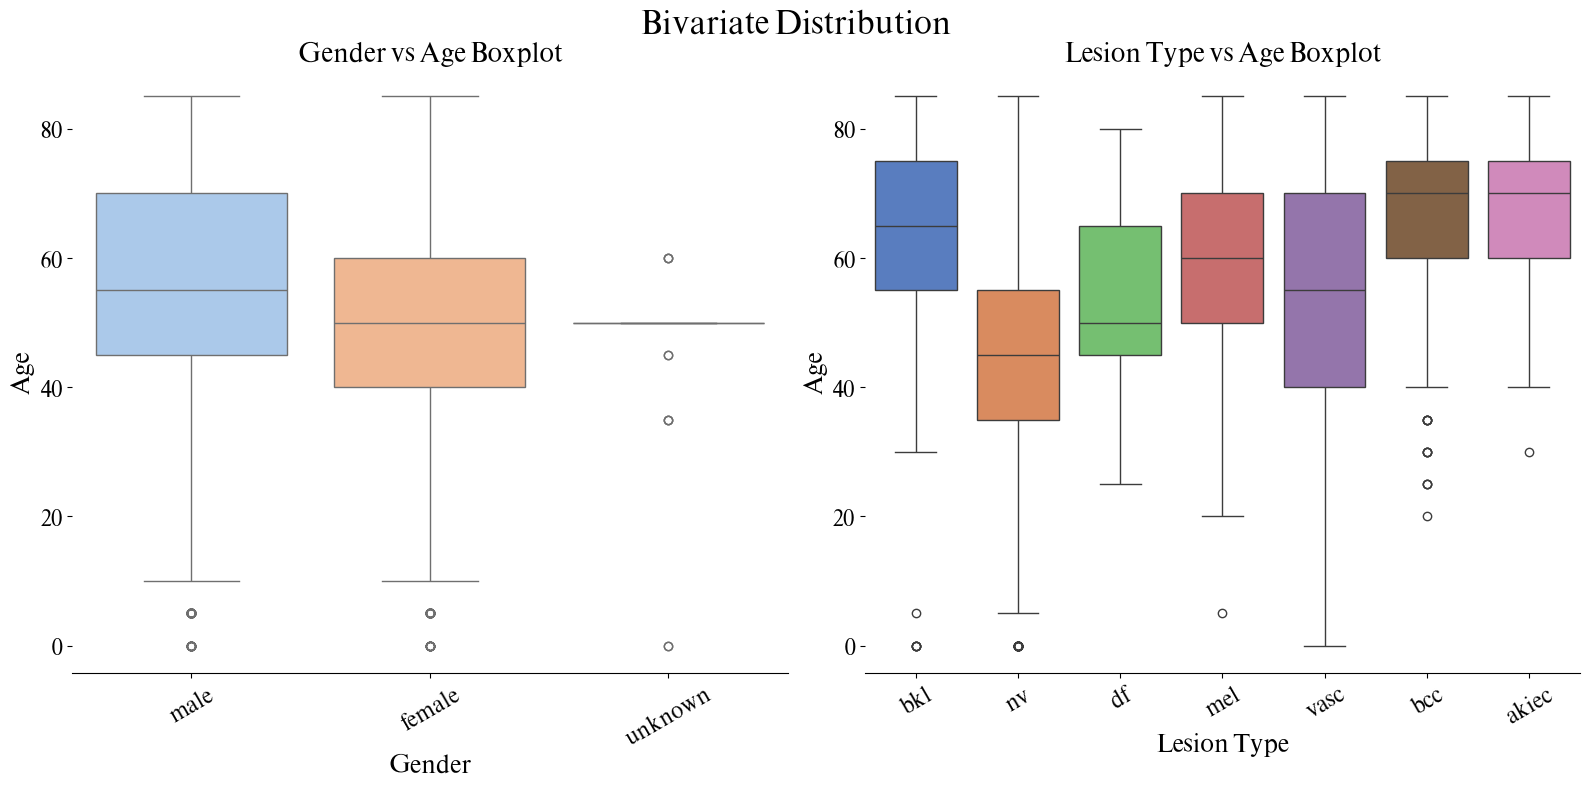

In [24]:
plot_age_boxplots(
    df=clean_df,
    fontsize=20,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/bivariate_distributions"
)

### **Handle unknown value for gender column**

In [25]:
mode_sex = clean_df["sex"].mode()[0] # หาฐานนิยมของอายุ Column
print(f"Mode of sex: {mode_sex}")
clean_df["sex"] = clean_df["sex"].replace("unknown", mode_sex) # แทนที่ค่า Unknown ด้วยฐานนิยม

Mode of sex: male


### **EDA Summary**

In [26]:
print("Metadata before cleaning detail")
print("-------------------------------------------")
print(f"Shape of metadata: {clean_df.shape}")
print(f"Row of metadata: {clean_df.shape[0]}")
print(f"Column of metadata: {clean_df.shape[1]}")
print("-------------------------------------------")
print("Check missing value")
print("-------------------------------------------")
print(clean_df.isnull().sum())
print("-------------------------------------------")
print("Check data type")
print("-------------------------------------------")
print(clean_df.dtypes)
print("Check duplicate value")
print("-------------------------------------------")
print(f"Duplicate value count : {clean_df.duplicated().sum()}")

Metadata before cleaning detail
-------------------------------------------
Shape of metadata: (10015, 10)
Row of metadata: 10015
Column of metadata: 10
-------------------------------------------
Check missing value
-------------------------------------------
lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
filepaths        0
cell_type        0
cell_type_idx    0
dtype: int64
-------------------------------------------
Check data type
-------------------------------------------
lesion_id          object
image_id           object
dx                 object
dx_type            object
age               float64
sex                object
localization       object
filepaths          object
cell_type        category
cell_type_idx        int8
dtype: object
Check duplicate value
-------------------------------------------
Duplicate value count : 0


### **Export metadata after cleaning**

In [27]:
clean_df.to_csv(f"{INDEX_PATH}/metadata_cleaning.csv", index=False)

## **Section 3: Verify images and create dataset tree directory**

In [29]:
process_df = pd.read_csv(f"{INDEX_PATH}/metadata_cleaning.csv")
process_df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                               filepaths  \
0      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
1      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
2      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
3      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
4      /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
...                                                  ...   
10010  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10011  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10012  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10013  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   
10014  /kaggle/input/skin-cancer-mnist-ham10000/HAM10...   

                           cell_type  cell_type_idx  
0      Benign keratosis-like lesions              2  
1      Benign keratosis-like lesions              2  
2      Benign keratosis-like lesions              2  
3      Benign keratosis-like lesions              2  
4      Benign keratosis-like lesions              2  
...                              ...            ...  
10010              Actinic keratoses              0  
10011              Actinic keratoses              0  
10012              Actinic keratoses              0  
10013              Actinic keratoses              0  
10014                       Melanoma              4  

[10015 rows x 10 columns]

In [30]:
def verify_images(df, filepaths_col):
    """
        สำหรับตรวจสอบรูปภาพ เพื่อสแกนหาว่ามีภาพที่เสียหรือเปิดไม่ได้หรือไม่
        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
        Return:
            List ที่เก็บชื่อไฟล์ที่พบปัญหา
    """
    corrupted_images = []
    filepaths = df[filepaths_col].values

    for filepath in tqdm(filepaths, desc="Verifying Images"):
        try:
            img = cv2.imread(filepath)
            if img is None:
                corrupted_images.append(filepath)
                os.remove(filepath) # ถ้าเจอภาพเสียลบออก
                print(f"Corrupted or unreadable image removed: {filepath}")
        except Exception as e:
            corrupted_images.append(filepath)
            os.remove(filepath) # ถ้าเจอภาพเสียลบออก
            print(f"Error verifying image: {filepath} - {e}")

    return corrupted_images

In [113]:
corrupted_images = verify_images(process_df, "filepaths")

Verifying Images: 100%|██████████| 10015/10015 [02:48<00:00, 59.45it/s]


In [114]:
print(f"Number of corrupted images: {len(corrupted_images)}")

Number of corrupted images: 0


In [31]:
def merge_directory(df, filepaths_col, labels_col, dest_dir, zip_dir=None):
    """
        สำหรับการ Merge source directorys ตั้งแต่ 2 แหล่งขึ้นไป รวมเป็น 1 เดียว พร้อมกับสร้าง Sub folder ตาม Label ของแต่ละภาพ
        Structure folder:
            Main folder
            |
            |__Label_1
               |_IMG_1.jpg
               |_IMG_2.jpg
               |...
            |__Label_2
               |_IMG_1.jpg
               |_IMG_2.jpg
               |...

        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ และ Column Label สำหรับอ้างอิง Label ของภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label ของภาพ
            dest_dir คือ directory ปลายทาง
            zip_dir (optional) รับค่าเป็น Path ไฟล์เพื่อ zip ไฟล์เก็บไว้
    """
    os.makedirs(dest_dir, exist_ok=True)
    print(f"Destination directory has been created at: {dest_dir}")

    labels = df[labels_col].unique().tolist()
    for label in labels:
        label_dir = os.path.join(dest_dir, label)
        os.makedirs(label_dir, exist_ok=True)

    filepaths = df[filepaths_col].values
    image_labels = df[labels_col].values

    for src_path, image_label in tqdm(zip(filepaths, image_labels), total=len(df), desc="Organizing Images"):
        filename = os.path.basename(src_path)
        dst_path = os.path.join(dest_dir, image_label, filename)
        shutil.copyfile(src_path, dst_path)

    if zip_dir:
        shutil.make_archive(zip_dir, "zip", dest_dir)
        print(f"Zip file has been created at: {zip_dir}")

In [32]:
merge_directory(
    df=process_df,
    filepaths_col="filepaths",
    labels_col="dx",
    dest_dir=MERGE_DIR,
    zip_dir=DATASET_ZIP_PATH
)

Destination directory has been created at: /content/ham10000Dataset


Organizing Images: 100%|██████████| 10015/10015 [02:19<00:00, 72.03it/s]


Zip file has been created at: /content/drive/MyDrive/CP461/mainProject/datasets/ham10000Dataset


In [74]:
def update_path(df, base_path, filepahts_col, labels_col):
    """
    ฟังก์ชันนี้ใช้อัปเดตเส้นทางไฟล์ (file path) ใน DataFrame
    โดยรวม base_path, label และชื่อไฟล์เข้าด้วยกัน

    Args:
        df (DataFrame): ข้อมูลที่มีคอลัมน์ไฟล์และป้ายกำกับ
        base_path (str): โฟลเดอร์หลักของไฟล์
        filepahts_col (str): ชื่อคอลัมน์ที่เก็บ path ของไฟล์เดิม
        labels_col (str): ชื่อคอลัมน์ที่เก็บ label ของไฟล์

    Returns:
        DataFrame: DataFrame ที่อัปเดตคอลัมน์ path ใหม่
    """
    filenames = df[filepahts_col].apply(os.path.basename)
    labels = df[labels_col]
    df[filepahts_col] = base_path + "/" + labels + "/" + filenames
    return df

In [38]:
NEW_PATH = "/content/ham10000Dataset"

process_df = update_path(
    df=process_df,
    base_path=NEW_PATH,
    filepahts_col="filepaths",
    labels_col="dx"
) # Rename path to match new path

In [40]:
process_df

lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                             filepaths  \
0        /content/ham10000Dataset/bkl/ISIC_0027419.jpg   
1        /content/ham10000Dataset/bkl/ISIC_0025030.jpg   
2        /content/ham10000Dataset/bkl/ISIC_0026769.jpg   
3        /content/ham10000Dataset/bkl/ISIC_0025661.jpg   
4        /content/ham10000Dataset/bkl/ISIC_0031633.jpg   
...                                                ...   
10010  /content/ham10000Dataset/akiec/ISIC_0033084.jpg   
10011  /content/ham10000Dataset/akiec/ISIC_0033550.jpg   
10012  /content/ham10000Dataset/akiec/ISIC_0033536.jpg   
10013  /content/ham10000Dataset/akiec/ISIC_0032854.jpg   
10014    /content/ham10000Dataset/mel/ISIC_0032258.jpg   

                           cell_type  cell_type_idx  
0      Benign keratosis-like lesions              2  
1      Benign keratosis-like lesions              2  
2      Benign keratosis-like lesions              2  
3      Benign keratosis-like lesions              2  
4      Benign keratosis-like lesions              2  
...                              ...            ...  
10010              Actinic keratoses              0  
10011              Actinic keratoses              0  
10012              Actinic keratoses              0  
10013              Actinic keratoses              0  
10014                       Melanoma              4  

[10015 rows x 10 columns]

In [45]:
process_df.to_csv(f"{INDEX_PATH}/metadata_updatepath.csv", index=False)

## **Section 4: Visualization images**

In [41]:
def visualize_image_by_class(df, filepaths_col, labels_col, labels_dict, save_path=None, fontsize=20, title="HAM10000 Dataset", num_images=7):
    """
        แสดงรูปภาพ Sample โดยแยกตาม Label ในแต่ละ Row
        Args:
            df คือ Pandas dataframe ที่มี Column Filepaths สำหรับอ้างอิงไปยังตำแหน่งของรูปภาพ และ Column Label สำหรับอ้างอิง Label ของภาพ
            filepaths_col คือ ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label ของภาพ
            labels_dict คือ dict ที่เก็บ key เป็นชื่อย่อของ Label และ value เป็นชื่อเต็มของ Label
            save_path (optional) หากใส่ filepath แบบ String จะทำการ Save Image เป็น .png และ .svg
            fontsize คือ ขนาด font (default = 18)
            title คือ ชื่อหัวข้อ
            num_images คือ จำนวนรูปภาพที่ต้องการแสดงในแต่ละแถว
    """
    unique_labels = df[labels_col].unique()
    num_classes = len(unique_labels)

    plt.figure(figsize=(num_images * 3, num_classes * 3))

    for i, label in enumerate(unique_labels):
        label_df = df[df[labels_col] == label]
        sample_paths = label_df[filepaths_col].sample(
            n=min(num_images, len(label_df)),
            random_state=SEED
        ).tolist()

        for j, filepath in enumerate(sample_paths):
            ax = plt.subplot(num_classes, num_images, i * num_images + j + 1)
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis("off")

            if j == 0:
                fullname = labels_dict.get(label, label)
                ax.set_title(f"{fullname} ({label})", loc="left", fontsize=fontsize, pad=10)

    plt.suptitle(title, fontsize=fontsize+2, weight="bold")
    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.05)

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

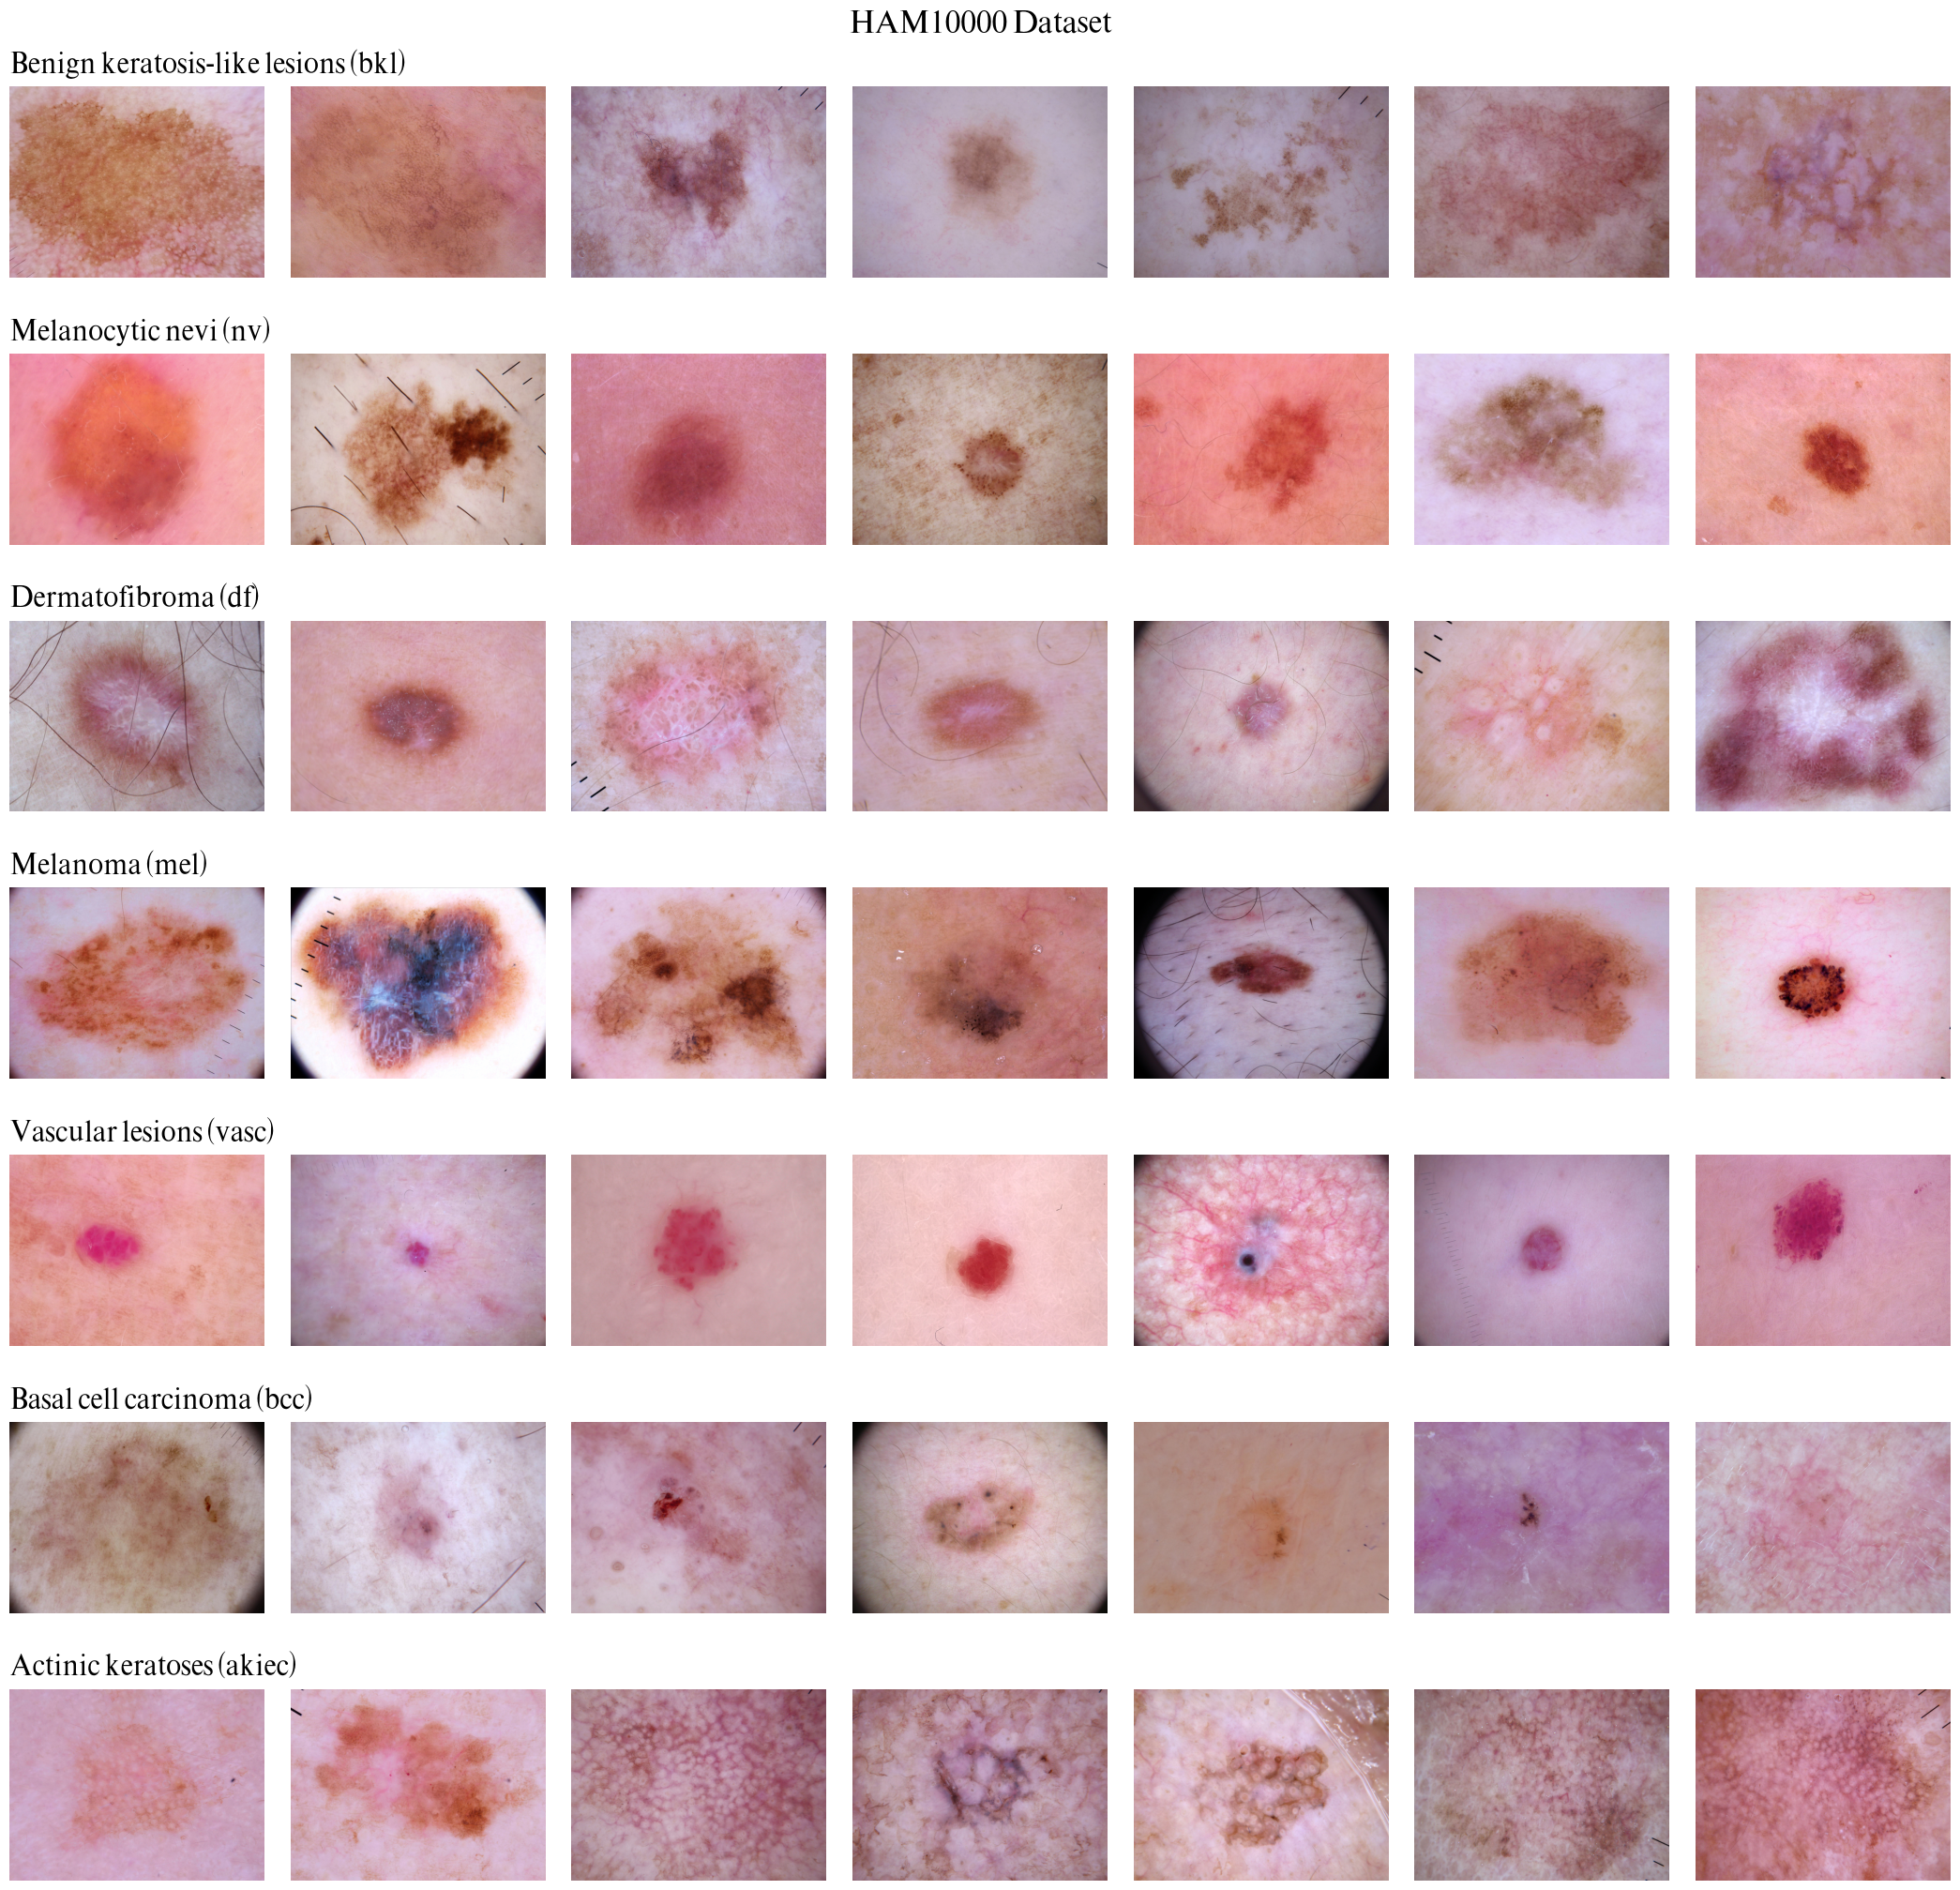

In [42]:
visualize_image_by_class(
    df=process_df,
    filepaths_col="filepaths",
    labels_col="dx",
    labels_dict=lesion_type_dict,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/visualize_by_class",
    fontsize=20
)

In [43]:
def plot_distribution(df, labels_col, save_path=None, fontsize=18, title="Class Distribution"):
    """
        แสดงจำนวนรูปภาพในแต่ละ Class แบบ Bar plot
        Args:
            df คือ Pandas dataframe ที่มี Column Label สำหรับอ้างอิง Label ของภาพ
            labels_col คือ ชื่อของ Column ที่เก็บ Label
            save_path (optional) หากใส่ filepath แบบ String จะทำการ Save Image เป็น .png และ .svg
            fontsize คือ ขนาด font (default = 18)
            title คือ ชื่อหัวข้อ
    """
    class_counts = df[labels_col].value_counts().reset_index()
    class_counts.columns = [labels_col, "count"]

    classes = sorted(df[labels_col].unique())
    palette = sns.color_palette("viridis", n_colors=len(classes))
    class_palette = {cls: palette[i] for i, cls in enumerate(classes)}

    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=labels_col,
        y="count",
        data=class_counts,
        hue=labels_col,
        palette=class_palette,
        dodge=False,
        legend=False,
        order=classes
    )

    plt.title(title, fontsize=fontsize+2, weight="bold")
    plt.xlabel("Classes", fontsize=fontsize)
    plt.ylabel("Number of Images", fontsize=fontsize)
    plt.xticks(rotation=45, ha="right", fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    for i, count in enumerate(class_counts.set_index(labels_col).loc[classes]["count"]):
        plt.text(i, count, str(count), ha="center", va="bottom", fontsize=fontsize-2)

    plt.tight_layout()

    if save_path:
        plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

    plt.show()

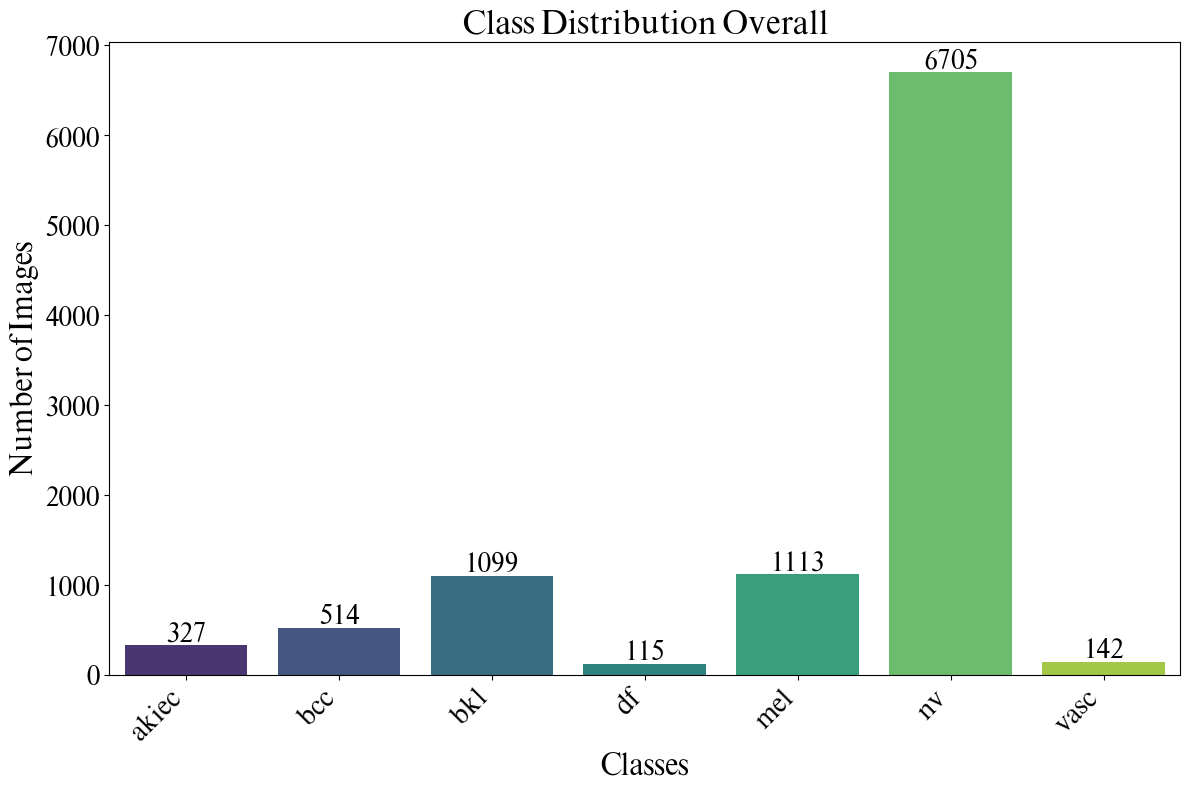

In [44]:
plot_distribution(
    df=process_df,
    labels_col="dx",
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/class_distribution",
    fontsize=20,
    title="Class Distribution Overall"
)

## **Section 5: Split data into Train, Validation and Test**

In [46]:
# หา Unique ตัวแบ่งกลุ่มที่จะ Split ข้อมูลโดยที่ไม่ซ้ำ
lesion_id = process_df.drop_duplicates(subset="lesion_id")
lesion_id = lesion_id[["lesion_id", "cell_type_idx"]]
print(f"Total images: {len(lesion_id)}")
print(f"Total unique lesions: {len(lesion_id)}")

Total images: 7470
Total unique lesions: 7470


**Split data into ratio train 80 validation 10 and test 10**

In [47]:
train_lesions, temp_lesions = sklearn.model_selection.train_test_split(
    lesion_id,
    test_size=0.20,
    stratify=lesion_id["cell_type_idx"],
    random_state=SEED
)

val_lesions, test_lesions = sklearn.model_selection.train_test_split(
    temp_lesions,
    test_size=0.5,
    stratify=temp_lesions["cell_type_idx"],
    random_state=SEED
)

print(f"Total lesions: {len(lesion_id)}")
print(f"Train lesions: {len(train_lesions)}")
print(f"Val lesions:   {len(val_lesions)}")
print(f"Test lesions:  {len(test_lesions)}")

Total lesions: 7470
Train lesions: 5976
Val lesions:   747
Test lesions:  747


In [48]:
train_ids = set(train_lesions["lesion_id"])
val_ids = set(val_lesions["lesion_id"])
test_ids = set(test_lesions["lesion_id"])

In [49]:
df_train = process_df[process_df["lesion_id"].isin(train_ids)].copy()
df_val = process_df[process_df["lesion_id"].isin(val_ids)].copy()
df_test = process_df[process_df["lesion_id"].isin(test_ids)].copy()

In [50]:
total_images = len(clean_df)

print(f"Total original images: {total_images}")
print(f"Train images: {len(df_train)} ({len(df_train)/total_images*100:.2f}%)")
print(f"Val images:   {len(df_val)} ({len(df_val)/total_images*100:.2f}%)")
print(f"Test images:  {len(df_test)} ({len(df_test)/total_images*100:.2f}%)")
print(f"Sum images:   {len(df_train) + len(df_val) + len(df_test)}")
print("-" * 30)

train_val_overlap = np.intersect1d(df_train["lesion_id"], df_val["lesion_id"])
train_test_overlap = np.intersect1d(df_train["lesion_id"], df_test["lesion_id"])
val_test_overlap = np.intersect1d(df_val["lesion_id"], df_test["lesion_id"])

# เพื่อรับประกันว่าข้อมูลจะไม่รั่วไหล
print(f"Overlap Train-Val: {len(train_val_overlap)}")
print(f"Overlap Train-Test: {len(train_test_overlap)}")
print(f"Overlap Val-Test: {len(val_test_overlap)}")

Total original images: 10015
Train images: 8020 (80.08%)
Val images:   1005 (10.03%)
Test images:  990 (9.89%)
Sum images:   10015
------------------------------
Overlap Train-Val: 0
Overlap Train-Test: 0
Overlap Val-Test: 0


## **Section 6: Preprocess data for modeling**

In [51]:
numeric_cols = ["age"]
categorical_cols = ["sex", "localization"] # ไม่รวม Target

preprocessing = sklearn.compose.ColumnTransformer(
    transformers=[
        ("numeric", sklearn.preprocessing.StandardScaler(), numeric_cols),
        ("category", sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ],
    remainder="drop" # ลบคอลัมน์อื่นที่ไม่เกี่ยวข้องทิ้งไป
)

In [52]:
#Fit preprocessor กับ df_train
print("Fitting preprocessor on df_train...")
preprocessing.fit(df_train)
print("Fit complete.")

Fitting preprocessor on df_train...
Fit complete.


In [53]:
# Transform ข้อมูลทั้ง 3 ชุด
print("Transforming datasets...")
X_meta_train = preprocessing.transform(df_train)
X_meta_val = preprocessing.transform(df_val)
X_meta_test = preprocessing.transform(df_test)

print("Transform complete.")

# ตรวจสอบผลลัพธ์
print(f"X_meta_train shape: {X_meta_train.shape}")
print(f"X_meta_val shape:   {X_meta_val.shape}")
print(f"X_meta_test shape:  {X_meta_test.shape}")

Transforming datasets...
Transform complete.
X_meta_train shape: (8020, 18)
X_meta_val shape:   (1005, 18)
X_meta_test shape:  (990, 18)


In [54]:
joblib.dump(preprocessing, f"{INDEX_PATH}/metadata_preprocessing.joblib")

['/content/drive/MyDrive/CP461/mainProject/datasets/indexSetting/metadata_preprocessing.joblib']

In [55]:
df_train.to_csv(f"{INDEX_PATH}/metadata_train.csv", index=False)
df_val.to_csv(f"{INDEX_PATH}/metadata_val.csv", index=False)
df_test.to_csv(f"{INDEX_PATH}/metadata_test.csv", index=False)

## **Section 7: Visualization transfrom image**

In [67]:
def visualize_augmentation(df, filepaths_col, transforms_sample, title,
                         n_rows, n_cols, n_samples=1,
                         seed=42, save_path=None, fontsize=16):
    """
    แสดงภาพต้นฉบับและภาพ Augmentation ใน Grid

    Args:
        df: DataFrame ที่มีคอลัมน์ Filepaths
        filepaths_col: ชื่อของ Column ที่เก็บตำแหน่งของรูปภาพ
        transforms_sample: list ของ tuple (name, albumentations transform)
        title: ชื่อ Title หลัก
        n_rows: จำนวนแถว
        n_cols: จำนวนหลัก
        n_samples: จำนวนภาพตัวอย่าง
        seed: random_state สำหรับ sample
        save_path: path สำหรับบันทึกรูป
        fontsize: ขนาดตัวอักษรของ title
    """
    samples = df.sample(n=n_samples, random_state=seed)

    for idx, row in samples.iterrows():
        img_path = row[filepaths_col]
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        n_aug = len(transforms_sample)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
        axes = axes.flatten()

        # Original image
        axes[0].imshow(img)
        axes[0].set_title("Original Image", fontsize=fontsize)
        axes[0].axis("off")

        # Augmented images
        for i, (name, aug) in enumerate(transforms_sample):
            aug_img = aug(image=img)["image"]
            axes[i+1].imshow(aug_img)
            axes[i+1].set_title(name, fontsize=fontsize)
            axes[i+1].axis("off")

        # ปิดแกนที่เหลือ
        for j in range(n_aug+1, len(axes)):
            axes[j].axis("off")

        fig.suptitle(title, fontsize=fontsize+2)
        plt.tight_layout()

        if save_path:
            plt.savefig(f"{save_path}.png", format="png", dpi=300, bbox_inches="tight")
            plt.savefig(f"{save_path}.svg", format="svg", bbox_inches="tight")

        plt.show()

In [68]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent={"x": (-0.2, 0.2), "y": (-0.15, 0.15)},
        rotate=(-30, 30),
        shear=(-20, 20),
        scale=(0.7, 1.3),
        border_mode=cv2.BORDER_REPLICATE,
        p=1.0
    ),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=0.4),
], seed=SEED)

In [69]:
# for visualization
preview_transforms = [
    ("Horizontal Flip", A.HorizontalFlip(p=1.0)),
    ("Translation", A.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.15, 0.15)}, border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Rotatation", A.Affine(rotate=(-30, 30), border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Shear", A.Affine(shear=(-20, 20), border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Zoom", A.Affine(scale=(0.7, 1.3), border_mode=cv2.BORDER_REPLICATE, p=1.0)),
    ("Brightness", A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0)),
    ("Hue", A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=15, p=1.0)),
]

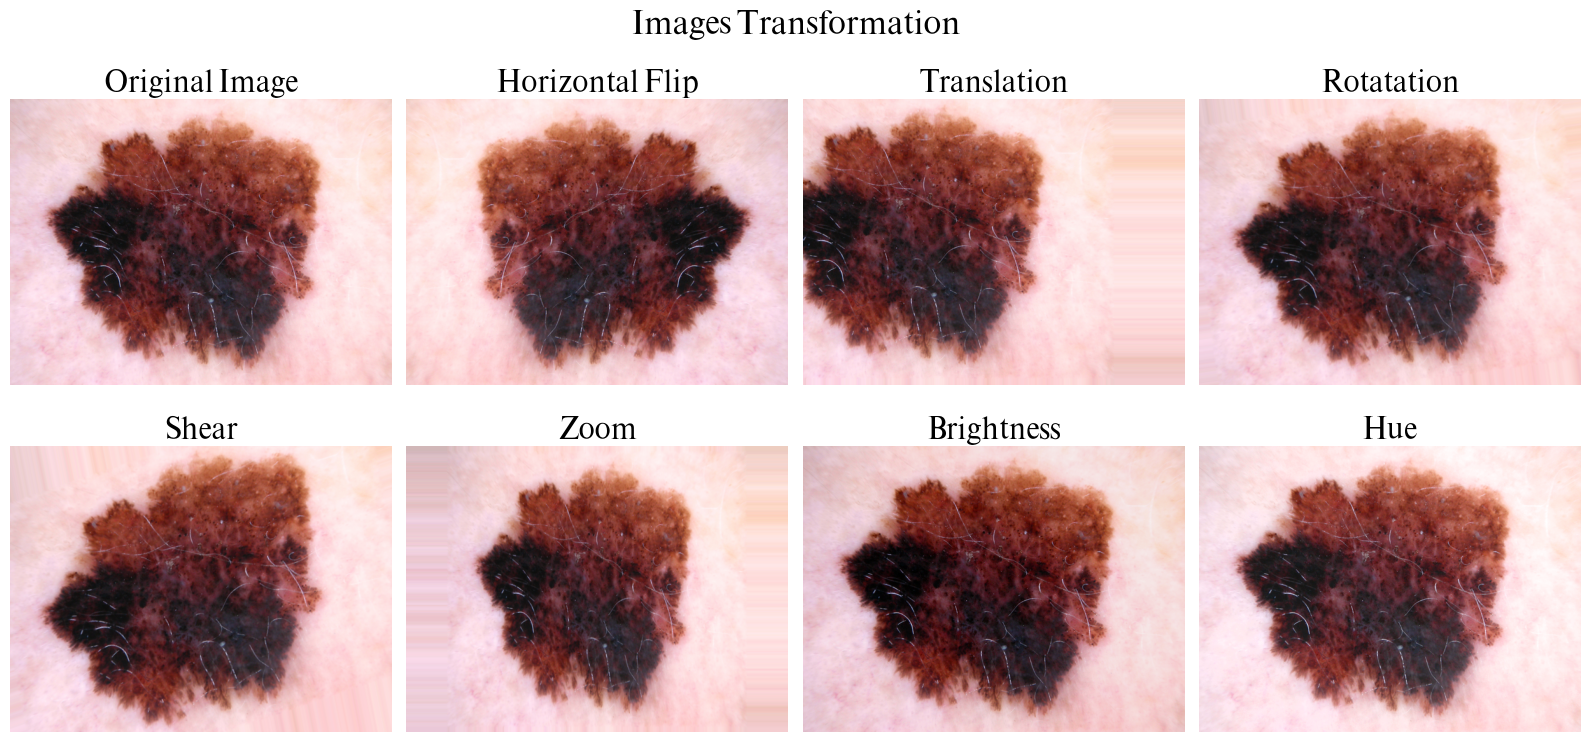

In [70]:
visualize_augmentation(
    df=df_train,
    filepaths_col="filepaths",
    transforms_sample=preview_transforms,
    title="Images Transformation",
    n_rows=2,
    n_cols=4,
    n_samples=1,
    seed=SEED,
    save_path=f"{ASSETS_VISUALIZE_IMG_PATH}/augmentation_sample",
    fontsize=20
)

## **Section 8: Preparation Summary**

In [71]:
labels = process_df["dx"].unique().tolist()

total_count = []
train_count = []
valid_count = []
test_count = []

for label in labels:
    total_count.append(process_df[process_df["dx"] == label].shape[0])
    train_count.append(df_train[df_train["dx"] == label].shape[0])
    valid_count.append(df_val[df_val["dx"] == label].shape[0])
    test_count.append(df_test[df_test["dx"] == label].shape[0])

summary_df = pd.DataFrame({
    "Label": labels,
    "Total (100%)": total_count,
    "Train (80.08%)": train_count,
    "Valid (10.03%)": valid_count,
    "Test (9.89%)": test_count
})
summary_df.to_csv(f"{INDEX_PATH}/dataset_description.csv", index=False)

print("Dataset overall description")
print("=======================================================================================================")
print(summary_df.to_string(index=False))
print("=======================================================================================================")
print(f"Training total count: {sum(train_count)}")
print(f"Validation total count: {sum(valid_count)}")
print(f"Testing total count: {sum(test_count)}")

Dataset overall description
Label  Total (100%)  Train (80.08%)  Valid (10.03%)  Test (9.89%)
  bkl          1099             881             108           110
   nv          6705            5368             668           669
   df           115              87              14            14
  mel          1113             895             116           102
 vasc           142             110              15            17
  bcc           514             414              50            50
akiec           327             265              34            28
Training total count: 8020
Validation total count: 1005
Testing total count: 990
